In [1]:
from config import *
from crnet_encoder_model import CRNETENCODER
from crnet_encoder_dataset import CRNETENCODERDataset
from crnet_encoder_loss import CRNETENCODERLoss

In [329]:
model_num = 85
model_path = f'/autodl-fs/data/crnet2/CE_model{model_num}.pth'

# test: 497,609,999,995,618,629,643,644,645,647,660,663,666,667,668,892,903
img_num = 1299
# image_path = f'/autodl-fs/data/Images/Train/img{img_num}.jpg'
image_path = f'/autodl-fs/data/Images/Test/img{img_num}.jpg'


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512), antialias=True)
])

image = Image.open(image_path).convert('RGB')
scale_width, scale_height = image.width / 128., image.height / 128.
input_tensor = transform(image).unsqueeze(0).to(device)



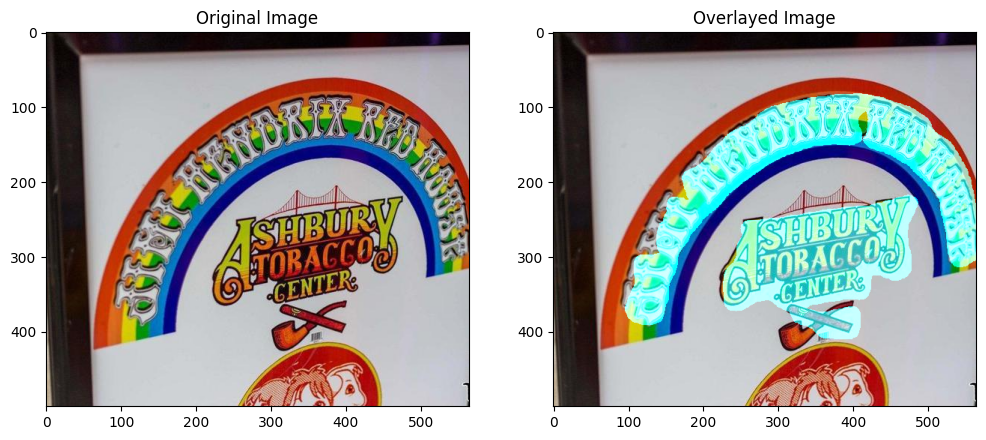

In [330]:
model = torch.load(model_path).to(device)
model.eval()

with torch.no_grad():
    outs = model(input_tensor)
    
tf = outs['tf_all']

# 将tf边缘1个单位置为tf里的最小值,用于减少边缘效应
padding = 1
min_value = tf.min().item()
# tf[:, :, :padding, :] = min_value
# tf[:, :, -padding:, :] = min_value
# tf[:, :, :, :padding] = min_value
# tf[:, :, :, -padding:] = min_value

# 对tf归一化
tf_min = tf.min()
tf_max = tf.max()
tf_normalized = (tf - tf_min) / (tf_max - tf_min)

# 将tf缩放到原图的尺寸
original_size = image.size  # (width, height)
tf_resized = F.interpolate(tf_normalized, size=original_size[::-1], mode='bilinear', align_corners=True)
tf_resized = tf_resized.squeeze().cpu().numpy()  

# 二值化
threshold = 0.2
tf_binary = (tf_resized > threshold).astype(np.uint8)

# 找到连通域
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(tf_binary, connectivity=8)

# 去除过小的连通域
proportion = 0
min_size = original_size[1]*original_size[1]*proportion/100.
# min_size = 100
for i in range(1, num_labels):  # 从1开始，因为0是背景
    if stats[i, cv2.CC_STAT_AREA] < min_size:
        tf_binary[labels == i] = 0

# 将处理后的二值图像转换为彩色遮罩
mask = np.zeros((original_size[1], original_size[0], 3), dtype=np.uint8)
mask[tf_binary > 0] = [0, 255, 255]  # 颜色

# mask = np.zeros((original_size[1], original_size[0], 3), dtype=np.uint8)
# mask[tf_resized > threshold] = [255, 0, 0]  # 红色

# 将遮罩叠加到原图上
image_np = np.array(image)  # 将PIL图像转换为NumPy数组
overlayed_image = cv2.addWeighted(image_np, 1, mask, 0.7, 0)

# 显示结果
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(overlayed_image)
plt.title('Overlayed Image')
plt.show()
